In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [59]:
# 1. Charger les données

chemain = "C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data.csv"
df = pd.read_csv(chemain)





In [ ]:
# 2. Préparation des données



# verification des colonnes engage_at et close_at sont au format datetime
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')

# Calcul de la marge commerciale (sales_margin)
df['sales_margin'] = df['Somme de close_value'] - df['sales_price']

# Calcul de la durée du cycle de vente (sales_cycle_days)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days

# Afficher les premières lignes pour vérifier
print(df[['Somme de close_value', 'sales_price', 'sales_margin', 'sales_cycle_days']].head())



# Remplir les valeurs manquantes dans les colonnes numériques


df['sales_cycle_days'] = df['sales_cycle_days'].fillna(df['sales_cycle_days'].mean())
df['Somme de close_value'] = df['Somme de close_value'].fillna(df['Somme de close_value'].mean())
#df = df.dropna(subset=['sales_margin'])
df['sales_margin'] = df['sales_margin'].fillna(df['sales_margin'].mean())


# Supprimer les colonnes non pertinentes
df = df.drop(columns=['deal_stage', 'account_id', 'account_name', 'opportunity_id', 'sale_id','engage_at', 'product_id', 'product_name', 'sale_id', 
                     'Somme de close_value', 'Somme de year_founded_at', 'sale_id.1', 'close_at', 'manager_id'])

# Encodage des variables catégoriques
label_encoders = {}
cat_columns = ['sector', 'product', 'sales_agent', 'regional_office', 'series', 'office_location', 'account', 'manager']

for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le





   Somme de close_value  sales_price  sales_margin  sales_cycle_days
0                   NaN       1096.0           NaN               NaN
1                   NaN         55.0           NaN               NaN
2                   NaN         55.0           NaN               NaN
3                   NaN          NaN           NaN               NaN
4                   NaN       5482.0           NaN               NaN


In [61]:
# 3. Sélection des caractéristiques et de la cible

X = df.drop(columns=['sales_margin'])
y = df['sales_margin']





In [62]:
# 4. Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [63]:
# 5. Division des données

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




In [64]:
# 6. # Validation croisée
model = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Validation croisée (MAE):", -np.mean(cv_scores))

# Entraîner le modèle
model.fit(X_train, y_train)


Validation croisée (MAE): 923.3039641486245


RandomForestRegressor(random_state=42)

In [65]:
# 7. Prédictions et évaluation
y_pred = model.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 612.5628580742658
Mean Squared Error (MSE): 1175024.0902245282
Root Mean Squared Error (RMSE): 1083.985281368953
R² Score: 0.10374214854837005


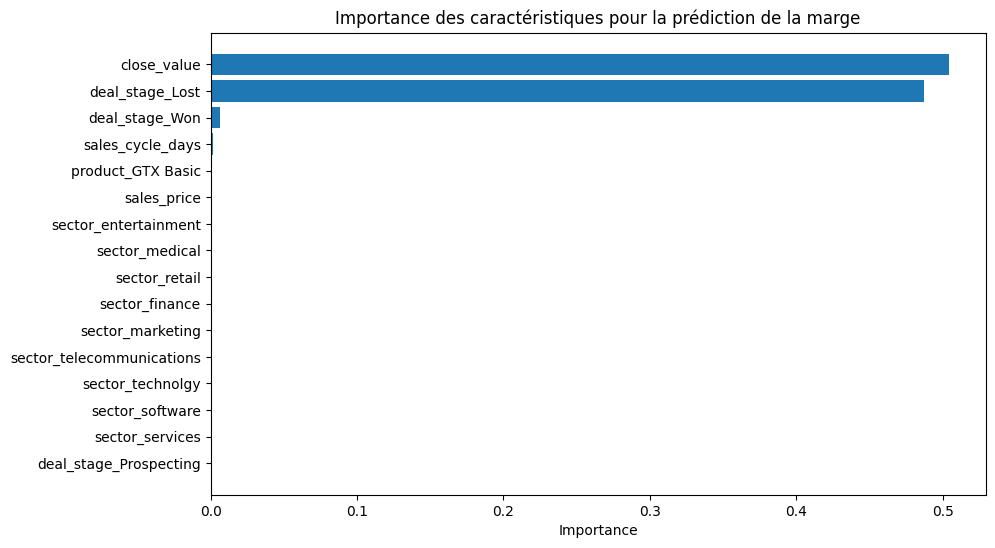

In [49]:
# Importance des caractéristiques
importances = model.feature_importances_
features = X.columns

# Graphique des importances
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), np.array(features)[sorted_idx])
plt.xlabel("Importance")
plt.title("Importance des caractéristiques pour la prédiction de la marge")
plt.show()


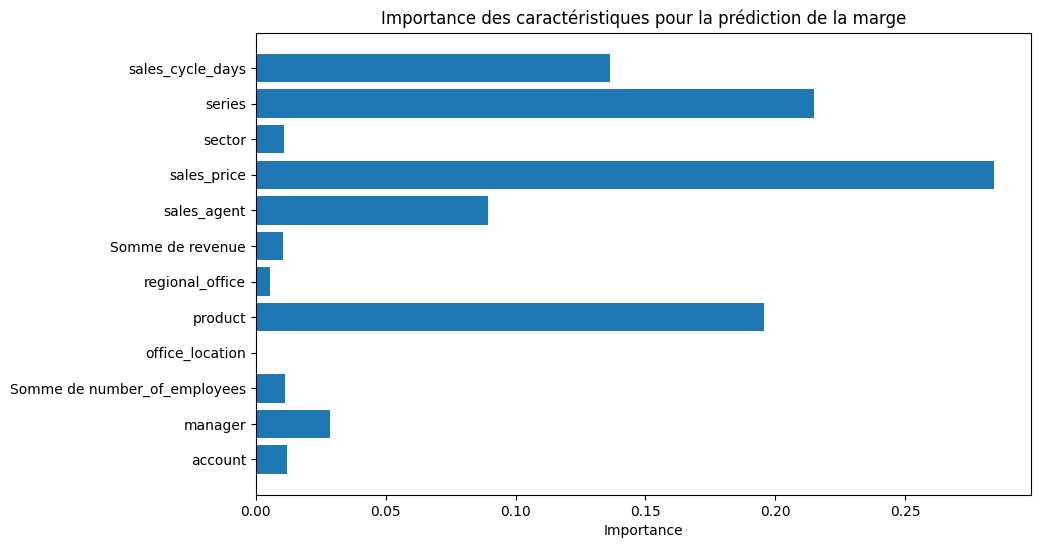

In [66]:

# Importance des caractéristiques
importances = model.feature_importances_
features = X.columns

# Graphique des importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Importance des caractéristiques pour la prédiction de la marge")
plt.show()


In [67]:
# 8. Ajouter les prédictions au DataFrame
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['predicted_margin'] = y_pred

# Rentabilité moyenne par secteur
sector_cols = [col for col in df.columns if 'sector' in col]
rentability_by_sector = df_test.groupby(sector_cols)['predicted_margin'].mean()

# Rentabilité moyenne par produit
product_cols = [col for col in df.columns if 'product' in col]
rentability_by_product = df_test.groupby(product_cols)['predicted_margin'].mean()

print("\nRentabilité moyenne par secteur:")
print(rentability_by_sector)
print("\nRentabilité moyenne par produit:")
print(rentability_by_product)



Rentabilité moyenne par secteur:
sector
-1.346567   -904.585655
-0.502854   -662.376257
 0.340860   -645.915913
 1.184574   -626.806410
Name: predicted_margin, dtype: float64

Rentabilité moyenne par produit:
product
-1.343197    -259.973218
-0.778829    -384.162229
-0.214460   -1168.670873
 0.349909    -910.497802
 0.914277   -1226.077461
 1.478646    -135.268912
Name: predicted_margin, dtype: float64


In [68]:
# 9. Analyse de la rentabilité par secteur
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['predicted_margin'] = y_pred

In [70]:
# Agrégation par secteur
rentability_by_sector = df_test.groupby([col for col in df_test.columns if 'sector' in col])['predicted_margin'].mean()
print("\nRentabilité moyenne par secteur (prédictions):")
print(rentability_by_sector)


Rentabilité moyenne par secteur (prédictions):
sector
-1.346567   -904.585655
-0.502854   -662.376257
 0.340860   -645.915913
 1.184574   -626.806410
Name: predicted_margin, dtype: float64


In [53]:
# Agrégation par produit
rentability_by_product = df_test.groupby([col for col in df_test.columns if 'product_' in col])['predicted_margin'].mean()
print("\nRentabilité moyenne par produit (prédictions):")
print(rentability_by_product)


Rentabilité moyenne par produit (prédictions):
product_GTX Basic
-3.824265   -10758.623490
 0.261488     -187.192553
Name: predicted_margin, dtype: float64


In [55]:
df_test.columns
df_test.shape

(100, 17)

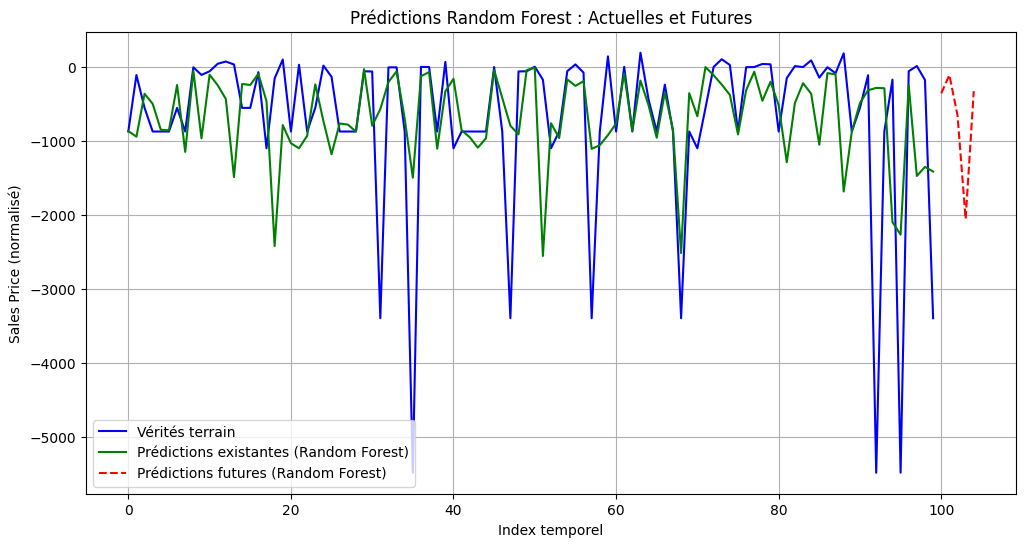

In [71]:


# Génération de nouvelles données simulées
future_data = pd.DataFrame({
    'account': [1, 2, 1, 2, 1],
    'manager': [3, 5, 1, 2, 4],
    'Somme de number_of_employees': [4540, 13756, 4540, 13756, 4540],
    'office_location': [1, 1, 1, 1, 1],
    'product': [2, 6, 3, 4, 1],
    'regional_office': [1, 2, 0, 2, 2],
    'Somme de revenue': [3178.24, 7708.38, 3178.24, 7708.38, 3178.24],
    'sales_agent': [27, 29, 11, 15, 6],
    'sales_price': [1096.0, 1096.0, 55.0, 5482.0, 550.0],
    'sector': [1, 3, 1, 3, 3],
    'series': [1, 1, 2, 3, 1],
    'sales_cycle_days': [43.65, 69.0, 43.65, 2.0, 11.0]
})

# Normaliser les nouvelles données
future_data_scaled = scaler.transform(future_data)

# Prédictions pour les nouvelles données
future_predictions = model.predict(future_data_scaled)

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="Vérités terrain", color="blue")
plt.plot(range(len(y_test)), y_pred, label="Prédictions existantes (Random Forest)", color="green")
plt.plot(range(len(y_test), len(y_test) + len(future_predictions)), future_predictions, 
         label="Prédictions futures (Random Forest)", color="red", linestyle='--')

plt.xlabel("Index temporel")
plt.ylabel("Sales Price (normalisé)")
plt.title("Prédictions Random Forest : Actuelles et Futures")
plt.legend()
plt.grid()
plt.show()
